In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
import tqdm

from compressor.wavelet_compressor import WaveletCompressor
from compressor.compressor import error

  0%|          | 0/100 [00:00<?, ?it/s]/home/tea_shroom/Programming/hydrophysical_data_compression/compressor/wavelet_compressor.py:70: UserWarning: Specified interpolation if not one of the defined ones. Continuing without interpolation.
  warnings.warn('Specified interpolation if not one of the defined ones. Continuing without interpolation.')
100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


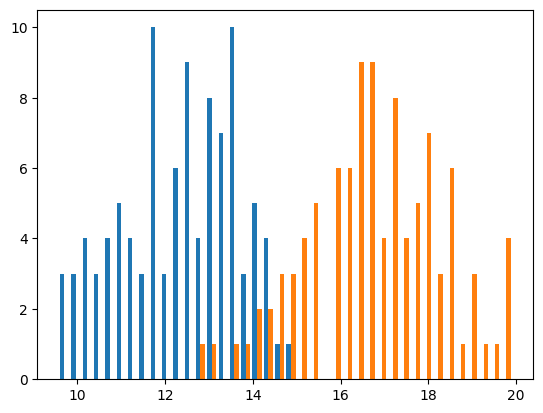

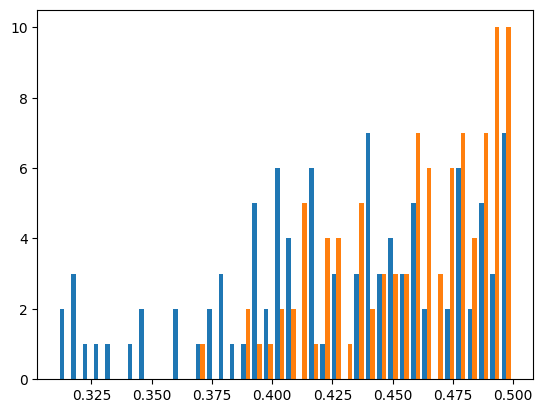

In [4]:
compressor_wavelet = WaveletCompressor(0.5, wavelet = 'haar', interpolation = 'wavelet')
compressor_none = WaveletCompressor(0.5, wavelet = 'haar', interpolation = 'none')

path_to_data = 'data/raw_temperature/'
data_describe = pd.read_csv(path_to_data + 'data_describe.csv').values
mask = np.load(path_to_data + data_describe[0, 0]) == 0

compression_coefficients_wavelet = []
compression_coefficients_none = []

errors_wavelet = []
errors_none = []

for img_name, _ in tqdm.tqdm(data_describe[:1000]):
    img = np.load(path_to_data + img_name)

    coeffs = compressor_wavelet.compress(img, mask)
    compression_coefficients_wavelet.append(compressor_wavelet.compression_coefficient(img, pywt.coeffs_to_array(coeffs)[0]))
    errors_wavelet.append(np.max((img - compressor_wavelet.decompress(coeffs)) * ~mask))

    coeffs = compressor_none.compress(img, mask)
    compression_coefficients_none.append(compressor_none.compression_coefficient(img, pywt.coeffs_to_array(coeffs)[0]))
    errors_none.append(np.max((img - compressor_wavelet.decompress(coeffs)) * ~mask))
    
plt.hist([compression_coefficients_none, compression_coefficients_wavelet], label=['none', 'wavelets'], bins = 40)
plt.show()
plt.hist([errors_none, errors_wavelet], label=['none', 'wavelets'], bins = 40)
plt.show()
